In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
from scipy.optimize import linear_sum_assignment
from sklearn.base import BaseEstimator, ClusterMixin, TransformerMixin
from torch.distributions import Categorical
from tqdm import tqdm

sys.path.append('../src')
from nets import MLP
from sim import make_dataset
from util import map_labels, show_dataset

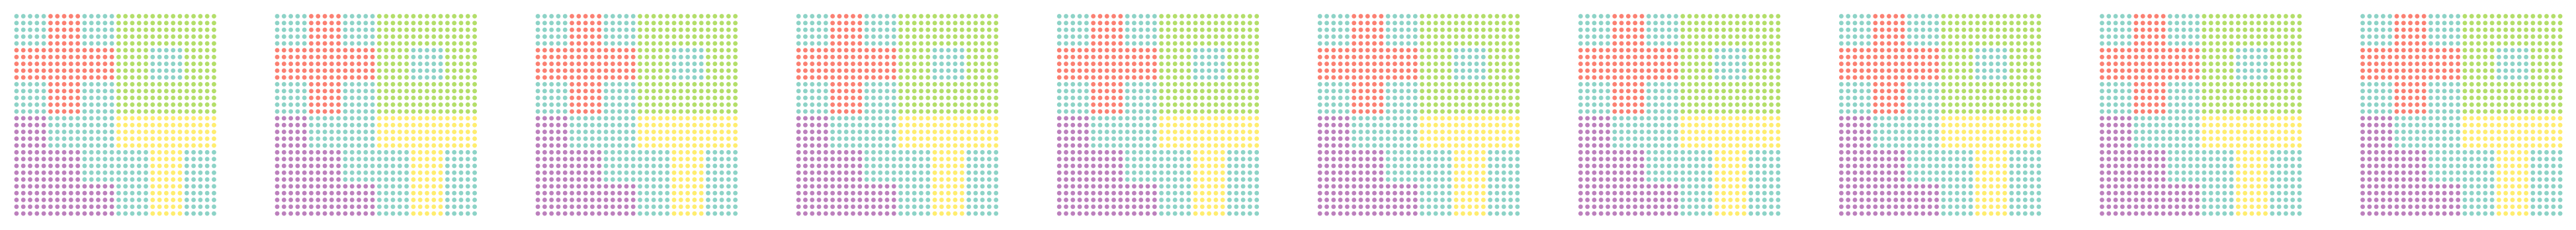

In [2]:
data, labels = make_dataset(('polygons',)*10, block_size=5, return_tensor=True)
show_dataset(data, labels)

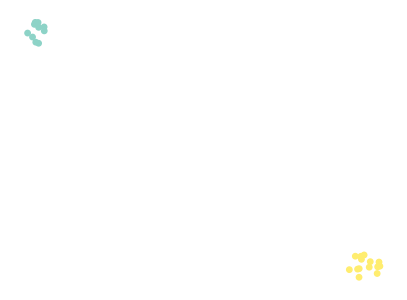

In [3]:
def relable(cs):
    cs, d, k = cs.copy(), {}, 0
    
    for i in range(len(cs)):
        j = cs[i]

        if j not in d:
            d[j] = k
            k += 1
        
        cs[i] = d[j]

    return cs

def generate(alpha=.7, N=None, N_min=5, N_max=100, no_ones=False):
    keep = True

    while keep:
        if N is None or N == 0:
            N = np.random.randint(N_min, N_max)
        clusters = np.zeros(N + 2)
        clusters[0], clusters[1], clusters[2] = 0, 1, alpha
        index_new = 2

        for n in range(N - 1):
            p = clusters/clusters.sum()
            z = np.argmax(np.random.multinomial(1, p))

            if z < index_new:
                clusters[z] += 1
            else:
                clusters[index_new] = 1
                index_new += 1
                clusters[index_new] = alpha

        clusters[index_new] = 0
        clusters = clusters.astype(np.int32)

        if no_ones:
            clusters = clusters[clusters != 1]

        N = int(np.sum(clusters))
        keep = N == 0

    K = np.sum(clusters > 0)

    return clusters, N, K

class Data:
    def __init__(self, x_dim=2, lamb=10, sigma=1, alpha=.7, N_min=5, N_max=50):
        self.x_dim = x_dim
        self.lamb = lamb
        self.sigma = sigma
        self.alpha = alpha
        self.N_min = N_min
        self.N_max = N_max

    def generate(self, N=None, batch_size=64, return_tensor=False):
        clusters, N, n_clusters = generate(self.alpha, N, self.N_min, self.N_max)
        cumsum = np.cumsum(clusters)
        data = np.empty((batch_size, N, self.x_dim))
        cs = np.empty(N, dtype=np.int32)

        for i in range(n_clusters):
            mu = np.random.normal(0, self.lamb, size=(self.x_dim*batch_size, 1))
            samples = np.random.normal(mu, self.sigma, size=(self.x_dim*batch_size, clusters[i + 1]))
            samples = np.swapaxes(samples.reshape((batch_size, self.x_dim, clusters[i + 1])), 1, 2)
            data[:, cumsum[i]:cumsum[i + 1], :] = samples
            cs[cumsum[i]:cumsum[i + 1]] = i + 1

        arr = np.arange(N)
        np.random.shuffle(arr)
        cs = cs[arr]
        data = data[:, arr, :]
        cs = relable(cs)
        medians = np.expand_dims(np.median(data, axis=1), 1)
        data = data - medians

        if return_tensor:
            return torch.tensor(data, dtype=torch.float32), torch.tensor(cs)

        # return data, cs, clusters, n_clusters
        return data, cs
    
generator = Data(x_dim=2)
data, labels = generator.generate()
show_dataset(np.hstack([np.zeros((data.shape[1], 1)), data[5]]), labels)
data = torch.tensor(data, dtype=torch.float32)

In [ ]:
def relabel(labels):
    topics, inverse = labels.unique(return_inverse=True)
    _, mapping = linear_sum_assignment(F.one_hot(inverse), maximize=True)
    labels = (labels[None, :] == topics[mapping][:, None]).int().argmax(0)

    return labels

def shuffle(data, labels=None, sort=True):
    idx = torch.randperm(data.shape[-2])
    data = data[:, idx] if len(data.shape) > 2 else data[idx]

    if labels is not None:
        labels = relabel(labels[idx]) if sort else labels[idx]

    return data, labels

class Encoder(nn.Module):
    """Implementation of a neural clustering process encoder. Based on methods 
    proposed by Ari Pakman, Yueqi Wang, Catalin Mitelut, JinHyung Lee, and Liam 
    Paninski.
    
    https://proceedings.mlr.press/v119/pakman20a.html

    Parameters
    ----------
    in_channels : int
        TODO
    h_channels : int | tuple | list, default=256
        TODO
    g_channels : int | tuple | list, default=512
        TODO
    f_channels : int | tuple | list, default=1
        TODO

    Attributes
    ----------
    h_model : MLP
        TODO
    u_model : MLP
        TODO
    g_model : MLP
        TODO
    f_model : MLP
        TODO

    Usage
    -----
    >>> model = Encoder(in_channels, *args, **kwargs)
    >>> output = model(data)
    """

    def __init__(self, in_channels, h_channels=256, g_channels=512, f_channels=1):
        super().__init__()

        self.in_channels = in_channels
        self.h_channels = (h_channels,) if isinstance(h_channels, int) else h_channels
        self.g_channels = (g_channels,) if isinstance(g_channels, int) else g_channels
        self.f_channels = (f_channels,) if isinstance(f_channels, int) else f_channels

        if self.f_channels[-1] != 1:
            self.f_channels += (1,)

        self.h_model = MLP(in_channels, *self.h_channels, activation='prelu')
        self.u_model = MLP(in_channels, *self.h_channels, activation='prelu')
        self.g_model = MLP(self.h_channels[-1], *self.g_channels, activation='prelu')
        self.f_model = MLP(self.h_channels[-1] + self.g_channels[-1], *self.f_channels, activation='prelu', out_bias=False)

    def build(self, data):
        self.batch_size = data.shape[0] if len(data.shape) > 2 else 1
        (self.n_samples, self.n_features), self.n_topics = data.shape[-2:], 1
        data = data.reshape(self.batch_size*self.n_samples, self.n_features)
        self.h = self.h_model(data).view(self.batch_size, self.n_samples, self.h_channels[-1])
        self.u = self.u_model(data).view(self.batch_size, self.n_samples, self.h_channels[-1])
        self.H = torch.zeros((self.batch_size, 1, self.h_channels[-1]))
        self.H[:, 0] = self.h[:, 0]
        self.U = self.u[:, 2:].sum(1)

        return self
    
    def update(self, sample, labels):
        n_topics = labels[:sample].unique().shape[0]

        if n_topics == self.n_topics:
            self.H[:, labels[sample - 1]] += self.h[:, sample - 1]
        else:
            self.H = torch.cat((self.H, self.h[:, sample - 1].unsqueeze(1)), 1)

        if sample == self.n_samples - 1:
            self.U = torch.zeros(self.batch_size, self.h_channels[-1])
        else:
            self.U -= self.u[:, sample]

        return n_topics
    
    def logprob(self, sample, topic):
        if topic == self.n_topics:
            H = torch.cat((self.H, self.h[:, sample].unsqueeze(1)), 1)
        else:
            H = self.H.clone()
            H[:, topic] += self.h[:, sample]

        H = H.view((self.batch_size*H.shape[1], self.h_channels[-1]))
        G = self.g_model(H)
        G = G.view(self.batch_size, G.shape[0]//self.batch_size, self.g_channels[-1]).sum(1)
        logprob = self.f_model(torch.cat((G, self.U), 1)).squeeze()

        return logprob
    
    def sample(self, sample, normalize=True, return_topics=True):
        logprobs = torch.zeros(self.batch_size, self.n_topics + 1)

        for k in range(self.n_topics + 1):
            logprobs[:, k] = self.logprob(sample, k)

        if normalize:
            m, _ = torch.max(logprobs, 1, keepdim=True)
            logprobs = logprobs - m - (logprobs - m).exp().sum(1, keepdim=True).log()

        if return_topics:
            topics = torch.multinomial(logprobs.exp(), 1).T[0]

            return topics, logprobs

        return logprobs

    def forward(self, data, labels):
        self.build(data)
        loss = 0

        for i in range(2, self.n_samples):
            self.n_topics = self.update(i, labels)
            loss -= self.sample(i, return_topics=False)[:, labels[i]].mean()

        return loss
    
    def predict(self, data, return_logprobs=False):
        self.build(data)
        predictions = torch.zeros((self.n_samples,) + (self.n_topics,)*return_logprobs)

        for i in range(self.n_samples):  # TODO
            predictions[i] = torch.mode(self.sample(i)[0])[0].item()

        return predictions
    
class NCP(nn.Module, BaseEstimator, ClusterMixin):
    """Implementation of a neural clustering process model. Based on methods 
    proposed by Ari Pakman, Yueqi Wang, Catalin Mitelut, JinHyung Lee, and Liam 
    Paninski.
    
    https://proceedings.mlr.press/v119/pakman20a.html

    Parameters
    ----------
    h_channels : int | tuple | list, default=256
        TODO
    g_channels : int | tuple | list, default=512
        TODO
    f_channels : int | tuple | list, default=1
        TODO

    Attributes
    ----------
    encoder : Encoder
        TODO
    optimizer : TODO
        TODO
    loss_log : list
        TODO
    _labels : Tensor
        TODO

    Usage
    -----
    >>> model = NCP(*args, **kwargs)
    >>> predictions = model.fit_predict(data, **kwargs)
    >>> logprobs = model.fit_transform(data, **kwargs)
    """

    def __init__(self, h_channels=256, g_channels=512, f_channels=1):
        super().__init__()

        self.h_channels = h_channels
        self.g_channels = g_channels
        self.f_channels = f_channels
        
        self.encoder = None
        self.optimizer = None
        self.loss_log = []
        self.n_topics = 1

    def build(self, in_channels, learning_rate=1e-4, weight_decay=1e-2):
        self.encoder = Encoder(in_channels, self.h_channels, self.g_channels, self.f_channels)
        self.optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate, weight_decay=weight_decay)

        return self
    
    def step(self, loss=None):
        self.optimizer.step()
        self.optimizer.zero_grad()

        if loss is not None:
            self.loss_log.append(loss)

        return self
    
    def forward(self, data, labels, grad=False):
        loss = self.encoder(data, labels)

        if grad:
            loss.backward()

        return loss.item()
    
    # def fit(self, data, labels, n_steps=100, n_permutations=6, learning_rate=1e-4, weight_decay=1e-2, verbosity=0, description='NCP'):
    #     self.build(data, learning_rate, weight_decay)

    #     for _ in tqdm(range(n_steps), description) if verbosity == 1 else range(n_steps):
    #         loss = 0

    #         for i in range(n_permutations):
    #             data, labels = shuffle(data, labels)
    #             loss += self(*shuffle(data, labels), grad=True)

    #         self.loss_log.append(loss/self.n_samples)
    #         self.step()

    #         print(f'step: {i}  nll: {np.mean(self.loss_log[-50:])}')

    #     return self

    def fit(self, generator, n_steps=200, n_permutations=6, learning_rate=1e-4, weight_decay=1e-2, verbosity=1, description='NCP'):
        self.build(generator.x_dim, learning_rate, weight_decay)

        for _ in tqdm(range(n_steps), description) if verbosity == 1 else range(n_steps):
            (data, labels), loss = generator.generate(return_tensor=True), 0

            for _ in range(n_permutations):
                loss += self(*shuffle(data, labels), grad=True)

            self.step(loss/data.shape[1])

        return self
    
    def predict(self, data):
        topics = self.encoder.predict(data)

In [65]:
h_channels = (128, 128, 128, 128, 256)
g_channels = (h_channels[-1], 128, 128, 128, 128, 128, 512)
f_channels = (h_channels[-1] + g_channels[-1], 128, 128, 128, 128)

model = NCP(h_channels, g_channels, f_channels)
model.fit(Data(2), n_steps=10);

NCP: 100%|██████████| 10/10 [00:16<00:00,  1.69s/it]


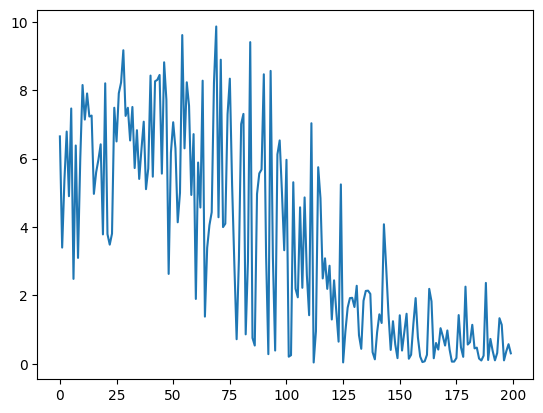

In [25]:
x = np.arange(len(model.loss_log))
plt.plot(x, model.loss_log)
plt.show()

In [44]:
b = True
a = torch.zeros((2,) + (4,)*b)
a.shape

torch.Size([2, 4])

torch.Size([49, 1])


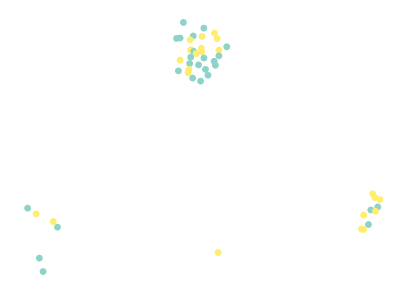

In [40]:
model.encoder.n_topics = 10
predictions = model.encoder.predict(data, return_logprobs=True)
show_dataset(np.hstack([np.zeros((data.shape[1], 1)), data[5]]), predictions)

In [11]:
x_dim = 2
h_channels = (128, 128, 128, 128, 256)
g_channels = (h_channels[-1], 128, 128, 128, 128, 128, 512)
f_channels = (h_channels[-1] + g_channels[-1], 128, 128, 128, 128)
model = Encoder(x_dim, h_channels, g_channels, f_channels)
generator = Data(x_dim)
losses, accs, perm_vars = [], [], []
it = 0
learning_rate = 1e-4
weight_decay = 1e-2
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
perms = 6
batch_size = 64
max_it = 200
learning_rates = {1200: 5e-5, 2200: 1e-5}
itt = it

while True:
    it += 1

    if it == max_it:
        break

    model.train()

    if it in learning_rates:
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rates[it], weight_decay=weight_decay)

    data, cs, clusters, K = generator.generate(None, batch_size)
    N = data.shape[1]
    loss_values = np.zeros(perms)

    while True:
        loss = 0

        for perm in range(perms):
            arr = np.arange(N)
            np.random.shuffle(arr)
            cs = cs[arr]
            data = data[:, arr]
            cs = relable(cs)
            this_loss = 0
            this_loss = model(torch.tensor(data, dtype=torch.float32), torch.tensor(labels))
            this_loss.backward()
            loss_values[perm] = this_loss.item()/N
            loss += this_loss

        perm_vars.append(loss_values.var())
        losses.append(loss.item()/N)
        optimizer.step()
        optimizer.zero_grad()
        print(f'step: {it}  nll: {np.mean(losses[-50:])}')
        break

/var/folders/qn/z7rm9myd1k73f0l5v7df09wc0000gn/T/ipykernel_54060/2052562622.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  this_loss = model(torch.tensor(data, dtype=torch.float32), torch.tensor(labels))


step: 1  nll: 4.066355387369792
step: 2  nll: 3.9727751413981123
step: 3  nll: 3.9982585075367694
step: 4  nll: 3.777617034529835
step: 5  nll: 3.8227408144385615
step: 6  nll: 3.8620887540652635
step: 7  nll: 3.8369602200139945
step: 8  nll: 3.814406223575549
step: 9  nll: 3.8320803812212265
step: 10  nll: 3.8524186868920296
step: 11  nll: 3.7947738140027667
step: 12  nll: 3.7082426718639865
step: 13  nll: 3.7095470341444807
step: 14  nll: 3.7309576052822813
step: 15  nll: 3.702019883907994
step: 16  nll: 3.70433539571219
step: 17  nll: 3.7123191638344633
step: 18  nll: 3.718724767479741
step: 19  nll: 3.729151484263104
step: 20  nll: 3.6658851045842504


KeyboardInterrupt: 

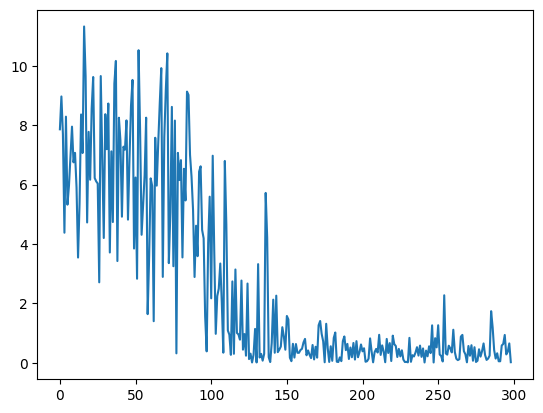

In [49]:
arr = np.arange(len(losses))
plt.plot(arr, losses)
plt.show()

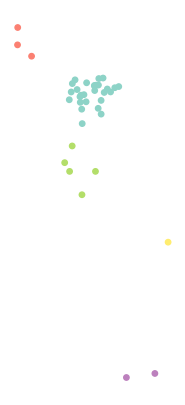

In [65]:
generator = Data(x_dim=2)
data, cs = generator.generate()
show_dataset(np.hstack([np.zeros((data.shape[1], 1)), data[0]]), cs)
data = torch.tensor(data, dtype=torch.float32)

In [66]:
model.encoder.predict(data)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

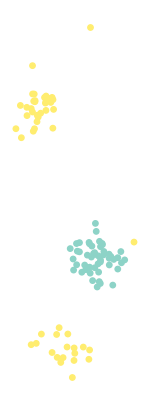

In [101]:
model = model.build(data)
predictions = []

for i in range(data.shape[1]):
    predictions.append(torch.mode(model.sample(i)[0])[0].item())

predictions = np.array(predictions)

show_dataset(np.hstack([np.zeros((data.shape[1], 1)), data[0]]), predictions)

In [ ]:
class Encoder(nn.Module):
    def __init__(self, in_channels, h_channels=128, g_channels=256, f_channels=1, max_topics=10000, **kwargs):
        super().__init__()

        self.h_channels = (h_channels,) if isinstance(h_channels, int) else h_channels
        self.g_channels = (g_channels,) if isinstance(g_channels, int) else g_channels
        self.f_channels = (f_channels,) if isinstance(f_channels, int) else f_channels
        self.max_topics = max_topics

        if self.f_channels[-1] != 1:
            self.f_channels += (1,)

        self.h_model = MLP(in_channels, *self.h_channels, **kwargs)
        self.u_model = MLP(in_channels, *self.h_channels, **kwargs)
        self.g_model = MLP(self.h_channels[-1], *self.g_channels, **kwargs)
        self.f_model = MLP(self.h_channels[-1] + self.g_channels[-1], *self.f_channels, **kwargs)

    def build(self, x):
        self.batch_size = x.shape[0] if len(x.shape) > 2 else 1
        (self.n_samples, self.n_features), self.n_topics = x.shape[-2:], 1
        x = x.view(self.batch_size, self.n_samples, self.n_features)
        self.batch_range = torch.arange(self.batch_size)
        self.h, self.u = self.h_model(x), self.u_model(x)
        self.q = torch.zeros(self.batch_size, self.n_samples, self.max_topics)
        self.H = torch.zeros(self.batch_size, self.max_topics, self.h_channels[-1])
        self.H[:, 0], self.U = self.h[:, 0], self.u[:, 2:].sum(1)
        self.G = self.g_model(self.H[:, 0])

        return self
    
    def sample(self, i):
        self.U = self.U - self.u[:, i]
        g = self.G[:, None, :] + self.g_model(self.H[:, :self.n_topics + 1] + self.h[:, None, i])
        U = torch.zeros(self.batch_size, self.n_topics + 1, self.h_channels[-1]) + self.U[:, None, :]
        self.q[:, i, :self.n_topics + 1] = self.f_model(torch.cat([g, U], 2))[..., 0]
        topics = self.q[:, i, :self.n_topics + 1].argmax(-1)
        self.n_topics += (topics == self.n_topics).any()
        H = self.H[self.batch_range, topics]
        self.G = self.G - self.g_model(H) + self.g_model(H + self.h[:, i])
        self.H[self.batch_range, topics] = self.H[self.batch_range, topics] + self.h[:, i]

        return topics

    def forward(self, x):
        self.build(x)
        topics = torch.zeros(self.batch_size, self.n_samples)

        for i in range(self.n_samples):
            topics[:, i] = self.sample(i)

        return topics

class NCP(nn.Module, BaseEstimator, ClusterMixin, TransformerMixin):
    def __init__(self, h_channels=128, g_channels=128, u_channels=256, f_channels=1):
        super().__init__()



        self.h_channels = (h_channels,) if isinstance(h_channels, int) else h_channels
        self.g_channels = (g_channels,) if isinstance(g_channels, int) else g_channels
        self.u_channels = (u_channels,) if isinstance(u_channels, int) else u_channels
        self.f_channels = (f_channels,) if isinstance(f_channels, int) else f_channels

        if self.f_channels[-1] != 1:
            self.f_channels += (1,)

In [103]:
model = Encoder(data.shape[-1])
optimizer = torch.optim.Adam(model.parameters(), 1e-3)

for i in range(10):
    topics = model(data)
    loss = (topics == cs).sum()
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn